In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
split_df = pd.read_csv('./dataset/ted_talks_en_processed.csv')
split_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44516 entries, 0 to 44515
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   transcript_with_fillers       44488 non-null  object
 1   filler_words_count            44516 non-null  int64 
 2   meaningless_connectors_count  44516 non-null  int64 
 3   word_count                    44516 non-null  int64 
 4   speak_duration                44516 non-null  int64 
 5   confidence                    44516 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.0+ MB


In [4]:
split_df['confidence'].value_counts()

confidence
0    24082
1    20434
Name: count, dtype: int64

In [6]:
numerical_features = ['filler_words_count', 'meaningless_connectors_count', 'word_count', 'speak_duration']
X = split_df[numerical_features]
y = split_df['confidence']

# Split data menjadi training dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standarisasi fitur numerik
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    
    # Hidden layer 1
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    # Hidden layer 2
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    # Hidden layer 3
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer untuk binary classification
])

In [8]:
# Tetapkan learning rate sebagai float biasa
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Kompilasi model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Tambahkan callback ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Latih model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[reduce_lr],
                    verbose=1)


Epoch 1/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8626 - loss: 1.1567 - val_accuracy: 0.9500 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 2/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.9379 - loss: 0.2624 - val_accuracy: 0.9652 - val_loss: 0.1365 - learning_rate: 0.0010
Epoch 3/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.9523 - loss: 0.1771 - val_accuracy: 0.9735 - val_loss: 0.1160 - learning_rate: 0.0010
Epoch 4/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.9580 - loss: 0.1540 - val_accuracy: 0.9702 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 5/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.9611 - loss: 0.1421 - val_accuracy: 0.9719 - val_loss: 0.1017 - learning_rate: 0.0010
Epoch 6/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.9699 - loss: 0.1218 - val_accuracy: 0.9746 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 7/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - accuracy: 0.9716 - l

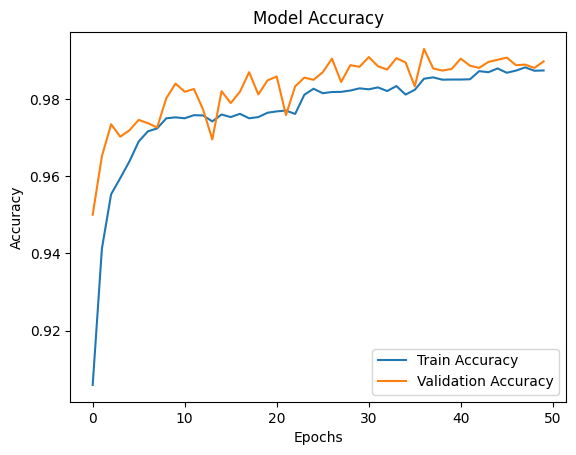

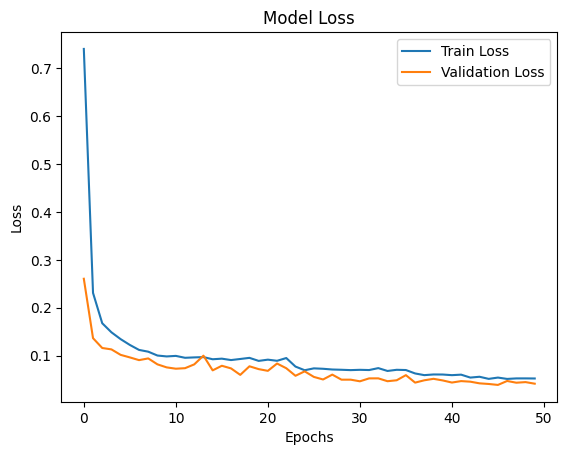

In [9]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Prediksi pada test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Binerisasi hasil prediksi
print(y_pred[:10])  # Tampilkan beberapa prediksi


279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
[[1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]]


In [32]:
import numpy as np
from collections import Counter
import re

# Fungsi preprocessing teks
def preprocess_text(text):
    text = re.sub(r'\([^)]*\)', '', text)  # Hapus teks dalam tanda kurung
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Hapus karakter spesial
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

# Fungsi untuk mengekstrak fitur dari teks
def extract_features(text):
    filler_words_list = ['um', 'uh']
    meaningless_connectors_list = ["so", "like", "and", "but", "because"]
    
    # Filler count
    filler_count = sum(1 for word in text.split() if word in filler_words_list)
    
    total_words = len(text.split())

    speak_duration = random.randint(35, 90) 

    
    # Meaningless connectors count
    meaningless_connectors_count = sum(1 for word in text.split() if word in meaningless_connectors_list)
    
    return [filler_count, meaningless_connectors_count, total_words, speak_duration]

# Fungsi untuk prediksi confidence
def predict_confidence(text, model, scaler):
    # Preprocess teks
    cleaned_text = preprocess_text(text)
    
    # Ekstrak fitur
    features = extract_features(cleaned_text)
    
    # Standarisasi fitur
    features_scaled = scaler.transform([features])  # Transform menggunakan scaler dari training
    
    # Prediksi menggunakan model
    confidence = model.predict(features_scaled)[0]
    
    # Konversi ke label 0/1
    confidence_label = int(confidence > 0.5)
    
    return confidence_label, confidence  # Label dan probabilitas

# Contoh penggunaan
# text= "today i want to talk about something very important which is climate change you know this issue affects all of us and it is crucial that we understand how our actions can impact the planet so let us start by considering small steps we can take in our daily lives things like using public transport reducing plastic waste and saving electricity can go a long way it is not about making drastic changes overnight but about building sustainable habits over time you know every small step counts and together we can make a difference so please think about the choices you make every day and how they can help protect our planet for future generations thank you"
text = "i ve been at mit for uh 44 years i went to ted i there s only one other person here i think who did that all the other teds and i went to them all under ricky s regime i talked about what the media lab was doing which today has almost 500 people in it and if you read the press last week um it uh actually said i quit the media lab i didn t quit the media lab i stepped down as chairman which was a kind uh of ridiculous title but someone else has taken it on and one of the things you can do as a professor is you stay on as a professor and i will now do for the rest of my life the one laptop per child which i ve sort of been doing for a year and a half anyway so i m going to tell"
confidence_label, confidence_prob = predict_confidence(text, model, scaler)

print(extract_features(text))
print(f"Predicted Confidence Label: {confidence_label}")
print(f"Confidence Probability: {confidence_prob}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[4, 7, 156, 74]
Predicted Confidence Label: 1
Confidence Probability: [0.9980659]


/Users/adrymirza/.local/share/virtualenvs/py-env-1-js1Xt8Gh/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/k0/zy4bfkn12qq1p0z88z5wtnlm0000gn/T/ipykernel_65883/449400729.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence_label = int(confidence > 0.5)


In [24]:
# save model
model.save('./model/numeric_model.h5')